#Letterboxd Movie Rating Prediction
##Fall 2024 Data Science Project
###Omari Allen, Elliott Duke, Kimberly Gordon


###Contributions
**Kimberly Gordon** came up with the idea for the project and located the original dataset (A). She also contributed to the data exploration and summary statistics (C), helped train and evaluate the machine learning models (E), assisted with visualizations and interpreting results (F), and helped write and revise the final report (G).

**Elliott Duke** gathered additional data from a secondary source and performed most of the preprocessing, including formatting and integrating the data into a SQLite database (B). They also worked on data exploration (C), designed and implemented the machine learning algorithms (D), conducted training and analysis (E), and contributed to the final report (G).

**Omari Allen** contributed to data exploration and statistical summaries (C), helped develop and tune the machine learning algorithms (D), worked on visualization and interpretation of the results (F), and participated in writing the final tutorial report (G).

###Introduction
We decided to analyze a dataset containing movie and user data from the popular movie-rating app Letterboxd. The dataset contains information about movies, such as runtime and genre, as well as information collected from users, such as ratings and likes. The main question we are trying to answer in this report is, “What aspects of a movie most heavily influence a movie’s overall rating on Letterboxd?” We additionally attempt to answer, “Is it even possible to predict the average rating of a movie using only basic metrics and information about the movie?”  This question leads us to further questions, such as: Does having many award-winning actors star in a movie influence its rating? What about the movie’s language or runtime?
Our main questions are important because the movie industry must cater towards the public, thus identifying the specific factors that affect the ratings given to a movie by the public would be valuable in allowing those involved in the creation and marketing of movies to make better informed decisions about how to produce a movie that will likely be more highly-rated among the public, shown through apps such as Letterboxd.

##Data Curation
After our initial review of the original dataset, we decided that only a few of the features provided were ones we could use to predict movie ratings, for instance, we dropped “Likes” and “List_appearances” to consolidate our data and focus on features we deemed relevant. Because of this, we found we needed to collect more data, and so used the TMDB website (The Movie Database) because it offered more data about most of the movies in the original Letterboxd dataset. To combine the two datasets and prepare the combined dataset for analysis, we had to:


*   Standardize column names by renaming certain columns for consistency between the two datasets
*   Remove duplicate entries by identifying and dropping any repeated records based on title, directors, runtime, and description
*   Split the “Director” field into two separate columns to account for films with multiple directors
*   Match each movie in the Letterboxd dataset with its corresponding entry in TMDB by comparing title, director, and movie description

Through this approach, we were able to successfully match over 9,700 of the original 10,000 entries from the Letterboxd dataset to their corresponding TMDB entries. However, we discovered that some of the entries in the original dataset were not actually movies, but television shows, and so dropped those entries.
Using the matched TMDB IDs, we gathered additional information for the corresponding films, such as budget, revenue, release date, MPAA rating, and top billing actors. While this enriched our dataset, we observed that some movies still had incomplete data on TMDB, especially when it came to budget and revenue. We used lists of Academy Award-nominated actors, directors, and studios from Wikipedia to create numerical indicators in our data that represent whether a film featured an award-nominated director, as well as how many award-nominated actors and movie studios were involved.

Data source citations:

Islam007, Sahil (2025). Letterbox Movie Classification Dataset [Data set]. Kaggle. https://www.kaggle.com/datasets/sahilislam007/letterbox-movie-classification-dataset.

Duke, Elliott (2025). TMDB Movie Rating Dataset [Data set]. TMDB. https://www.themoviedb.org/?language=en-US.


In [1]:
# Imports
import pandas as pd
import sqlite3
import requests
import re
import ast
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Combined_data.csv')

# Create a new SQLite database file
conn = sqlite3.connect("Movie_database.sqlite")
cur = conn.cursor()

df.to_sql('Working_data', conn, if_exists='replace', index=False)

cur.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Use a local copy to avoid Google Drive locks
!cp "/content/Movie_database.sqlite" "/content/Movie_database.sqlite"

cp: '/content/Movie_database.sqlite' and '/content/Movie_database.sqlite' are the same file



##Exploratory data analysis
We standardized the genre data by consolidating similar or overlapping genres to reduce the number of unique genre options. Each genre was then separated into individual binary columns using one-hot encoding to make them easier to analyze.


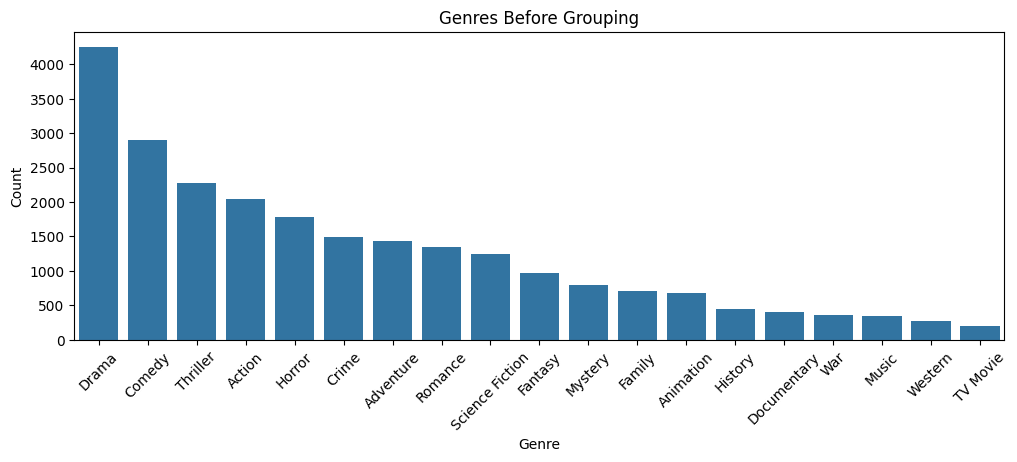

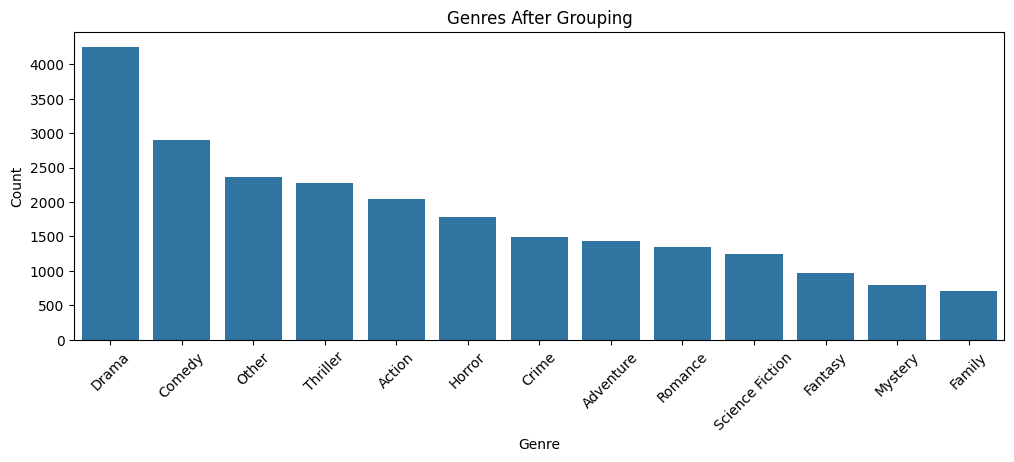

In [3]:
# Connect to DB
conn = sqlite3.connect("Movie_database.sqlite")
cur = conn.cursor()

# Genre replacements and exclusions
genre_replacements = {
    "Captivating vision and Shakespearean drama": "Drama",
    "Historical battles and epic heroism": "War",
    "Fantasy adventure, heroism, and swordplay": "Fantasy",
    "Superheroes in action-packed battles with villains": "Action",
    "Epic adventure and breathtaking battles": "Adventure",
    "Epic heroes": "Action",
    "Epic history and literature": "History"
}
genres_to_remove = {"Show All…"}

# Safe parsing from string to list
def safe_parse(val):
    try:
        parsed = ast.literal_eval(val)
        return parsed if isinstance(parsed, list) else []
    except:
        return []

# Replace mapped genres, remove noise
def clean_genres(genre_list):
    return [
        genre_replacements.get(genre, genre)
        for genre in genre_list
        if genre not in genres_to_remove
    ]

# Read raw genres and clean them
cur.execute("SELECT rowid, Genres FROM Working_data")
rows = cur.fetchall()

# Parse and clean genre lists
parsed_data = []
all_cleaned_genres = []

for rowid, genre_str in rows:
    raw_list = safe_parse(genre_str)
    cleaned_list = clean_genres(raw_list)
    parsed_data.append((rowid, cleaned_list))
    all_cleaned_genres.extend(cleaned_list)

# Collapse low-frequency genres
genre_counts = Counter(all_cleaned_genres)
low_freq_genres = {genre for genre, count in genre_counts.items() if count < 700}

og_genres, og_counts = zip(*genre_counts.most_common())  # sorts from most to least
# Plot
plt.figure(figsize=(12, 4))
sns.barplot(x=og_genres, y=og_counts)
plt.xticks(rotation=45)
plt.title("Genres Before Grouping")
plt.xlabel("Genre")
plt.ylabel("Count")

# Collapse low-frequency genres
low_freq_genres = {genre for genre, count in genre_counts.items() if count < 700}

# Replace low-freq genres with "Other", keep one "Other" max
def collapse_genres(genres):
    updated = ["Other" if genre in low_freq_genres else genre for genre in genres]
    result = []
    seen_other = False
    for g in updated:
        if g == "Other":
            if not seen_other:
                result.append(g)
                seen_other = True
        else:
            result.append(g)
    return result


cur.execute("UPDATE Working_data SET Genres = '[]' WHERE rowid = 1")
conn.commit()


# Update database with modified genre lists
for rowid, genre_list in parsed_data:
    cleaned = collapse_genres(genre_list)
    genre_str = str(cleaned)  # Store as stringified list
    cur.execute("UPDATE Working_data SET Genres = ? WHERE rowid = ?", (genre_str, rowid))

conn.commit()

# One-hot encode the cleaned genres using pandas
df = pd.read_sql_query("SELECT rowid, * FROM Working_data", conn)

df["Genres"] = df["Genres"].apply(safe_parse)

# Target genres to one-hot encode
target_genres = [
    "Drama", "Comedy", "Other", "Thriller", "Action", "Horror", "Crime",
    "Adventure", "Romance", "Science_fiction", "Fantasy", "Mystery", "Family"
]

# Add one-hot columns
for genre in target_genres:
    df[genre] = df["Genres"].apply(lambda g: 1 if genre in g else 0)

# Add columns to SQLite table if missing
existing_cols = pd.read_sql_query("PRAGMA table_info(Working_data);", conn)["name"].tolist()

for genre in target_genres:
    if genre not in existing_cols:
        cur.execute(f"ALTER TABLE Working_data ADD COLUMN '{genre}' INTEGER DEFAULT 0")

# Update the table with one-hot values
for _, row in df.iterrows():
    updates = ", ".join([f"'{genre}' = {row[genre]}" for genre in target_genres])
    cur.execute(f"""
        UPDATE Working_data
        SET {updates}
        WHERE rowid = ?
    """, (row["rowid"],))

# Re-fetch cleaned genre lists from DB to reflect collapsing
df_after = pd.read_sql_query("SELECT Genres FROM Working_data", conn)
df_after["Genres"] = df_after["Genres"].apply(safe_parse)

# Flatten and count
collapsed_genres_flat = [genre for sublist in df_after["Genres"] for genre in sublist]
collapsed_genre_counts = Counter(collapsed_genres_flat)

# Plot updated genre counts
genres_after, counts_after = zip(*collapsed_genre_counts.most_common())
plt.figure(figsize=(12, 4))
sns.barplot(x=genres_after, y=counts_after)
plt.xticks(rotation=45)
plt.title("Genres After Grouping")
plt.xlabel("Genre")
plt.ylabel("Count")


# Finalize
conn.commit()
conn.close()

We also processed the film certification (MPAA rating) by creating a new variable with six distinct rating categories (e.g., G = 1, PG = 2), as well as creating a one hot encoding variable for each one (e.g., G, PG, R) so that we could test both. For the language column, we grouped together languages with very few entries into a single category, “Other.” We then created a binary variable for whether the film was originally in English or not.

We also noticed that there were outliers in the “Academy_award_actors column”, so we decided to cap that column at 20.


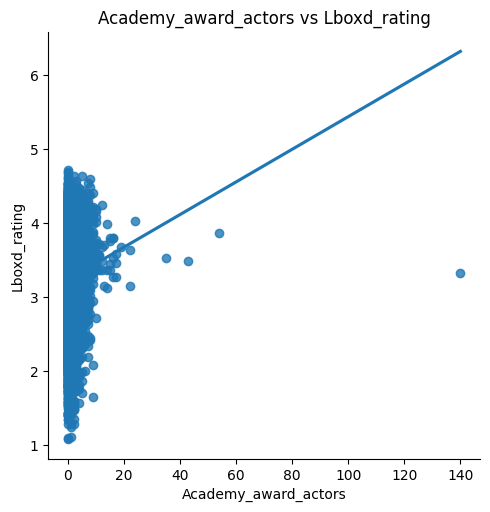

Correlation: 0.1027424037481972


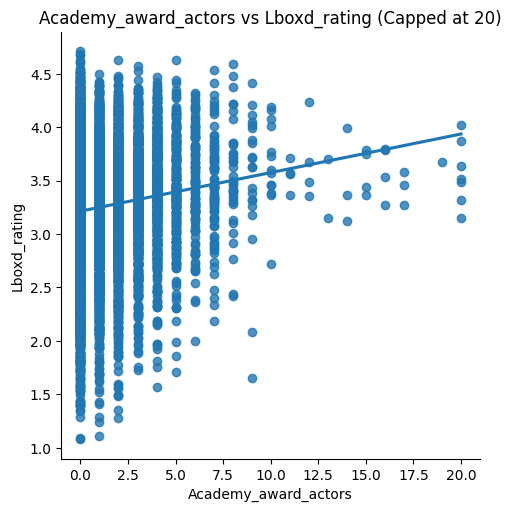

Correlation (capped): 0.12947137730497155


In [4]:
# Connect to DB
conn = sqlite3.connect("Movie_database.sqlite")
cur = conn.cursor()

# Add Certification_number
cur.execute("ALTER TABLE Working_data ADD COLUMN Certification_number INTEGER;")

# Update Certification_number values
cur.execute("""
    UPDATE Working_data
    SET Certification_number = CASE Movie_certificaiton
        WHEN 'G' THEN 1
        WHEN 'PG' THEN 2
        WHEN 'PG-13' THEN 3
        WHEN 'R' THEN 4
        WHEN 'NC-17' THEN 5
        WHEN 'NR' THEN 6
        ELSE NULL
    END;
""")

# Add one-hot columns
columns_to_add = ['Is_g', 'Is_pg', 'Is_pg13', 'Is_r', 'Is_nc17', 'Is_nr']
for col in columns_to_add:
    try:
        cur.execute(f"ALTER TABLE Working_data ADD COLUMN {col} INTEGER DEFAULT 0;")
    except sqlite3.OperationalError as e:
        if f"duplicate column name: {col}" in str(e).lower():
            print(f"Column '{col}' already exists, skipping.")
        else:
            raise

# Reset values to 0 (if needed)
cur.execute("""
    UPDATE Working_data
    SET Is_g = 0, Is_pg = 0, Is_pg13 = 0,
        Is_r = 0, Is_nc17 = 0, Is_nr = 0;
""")

# Set one-hot flags based on Certification_number
cert_map = {
    1: "Is_g",
    2: "Is_pg",
    3: "Is_pg13",
    4: "Is_r",
    5: "Is_nc17",
    6: "Is_nr"
}
for cert_num, col in cert_map.items():
    cur.execute(f"""
        UPDATE Working_data
        SET {col} = 1
        WHERE Certification_number = {cert_num};
    """)

# Add and update Is_english column
cur.execute("ALTER TABLE Working_data ADD COLUMN Is_english INTEGER DEFAULT 0;")

cur.execute("""
    UPDATE Working_data
    SET Is_english = CASE
        WHEN Original_language = 'English' THEN 1
        ELSE 0
    END;
""")

X_axis = 'Academy_award_actors'
Y_axis = 'Lboxd_rating'

# Plot with outliers
sns.lmplot(data=df, x=X_axis, y=Y_axis, ci=None)
plt.title(f"{X_axis} vs {Y_axis}")
plt.show()

# Correlation calculation
correlation = df[X_axis].corr(df[Y_axis])
print(f"Correlation: {correlation}")

# Cap Academy_award_actors at 20
cur.execute("""
    UPDATE Working_data
    SET Academy_award_actors = CASE
        WHEN Academy_award_actors > 20 THEN 20
        ELSE Academy_award_actors
    END;
""")

df = pd.read_sql("SELECT * FROM Working_data", conn)  # Make sure `con` is your database connection

# Plot without outliers
sns.lmplot(data=df, x=X_axis, y=Y_axis, ci=None)
plt.title(f"{X_axis} vs {Y_axis} (Capped at 20)")
plt.show()

# Correlation calculation
correlation = df[X_axis].corr(df[Y_axis])
print(f"Correlation (capped): {correlation}")


# Finalize
conn.commit()
conn.close()

Finally, we noticed that many films had a suspiciously identical rating value of approximately 3.2685. This suggested that missing ratings may have been filled in with an average value by whoever put the original dataset together, potentially biasing the data. We addressed this by implementing a rule to replace these values when better data from TMDB was available.


In [5]:
# Connect to DB
conn = sqlite3.connect("Movie_database.sqlite")
cur = conn.cursor()

# Add the Combined_rating column if it doesn't exist
cur.execute("ALTER TABLE Working_data ADD COLUMN Combined_rating REAL;")

# Fetch relevant ratings
cur.execute("SELECT Lboxd_ID, Lboxd_rating, TMDB_rating FROM Working_data")
rows = cur.fetchall()

# Compute and update Combined_rating
fallback_lboxd = 3.268535187347416  # The value that means "missing" for Lboxd
for row in rows:
    ID, lboxd, tmdb = row

    try:
        lboxd = float(lboxd) if lboxd is not None else fallback_lboxd
        tmdb = float(tmdb) if tmdb is not None else 0.0
    except ValueError:
        print(f"Skipping row with invalid values: {row}")
        continue

    if abs(lboxd - fallback_lboxd) >= 0.00001:
        newVal = lboxd
    else:
        # Scale TMDB rating (0–10) into 1–5
        oldMin, oldMax = 0.0, 10.0
        newMin, newMax = 1.0, 5.0
        if tmdb >= oldMax:
            newVal = newMax
        elif tmdb <= oldMin:
            newVal = newMin
        else:
            newVal = ((tmdb - oldMin) / (oldMax - oldMin)) * (newMax - newMin) + newMin

    # Update Combined_rating in the table
    cur.execute(
        "UPDATE Working_data SET Combined_rating = ? WHERE Lboxd_ID = ?",
        (newVal, ID)
    )

# Finalize
conn.commit()
conn.close()

In [6]:
# Connect to DB
conn = sqlite3.connect("Movie_database.sqlite")
table_name = "Working_data"

# Load table into pandas DataFrame and write to CSV
df = pd.read_sql_query(f"SELECT * FROM {table_name};", conn)
df.to_csv(f"Final_data.csv", index=False)

# Close the connection
conn.close()

##Primary analysis
The best machine learning technique for this dataset and this question is regression. The goal of our analysis is to predict a continuous variable, the average user rating of a movie, based on various features such as genre, runtime, release year, and number of ratings. Regression is the best technique to use because the target variable (movie rating) is continuous, not categorical. Now, we need to decide what kind of model to use.

In [7]:
# Necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
from sklearn.base import clone

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

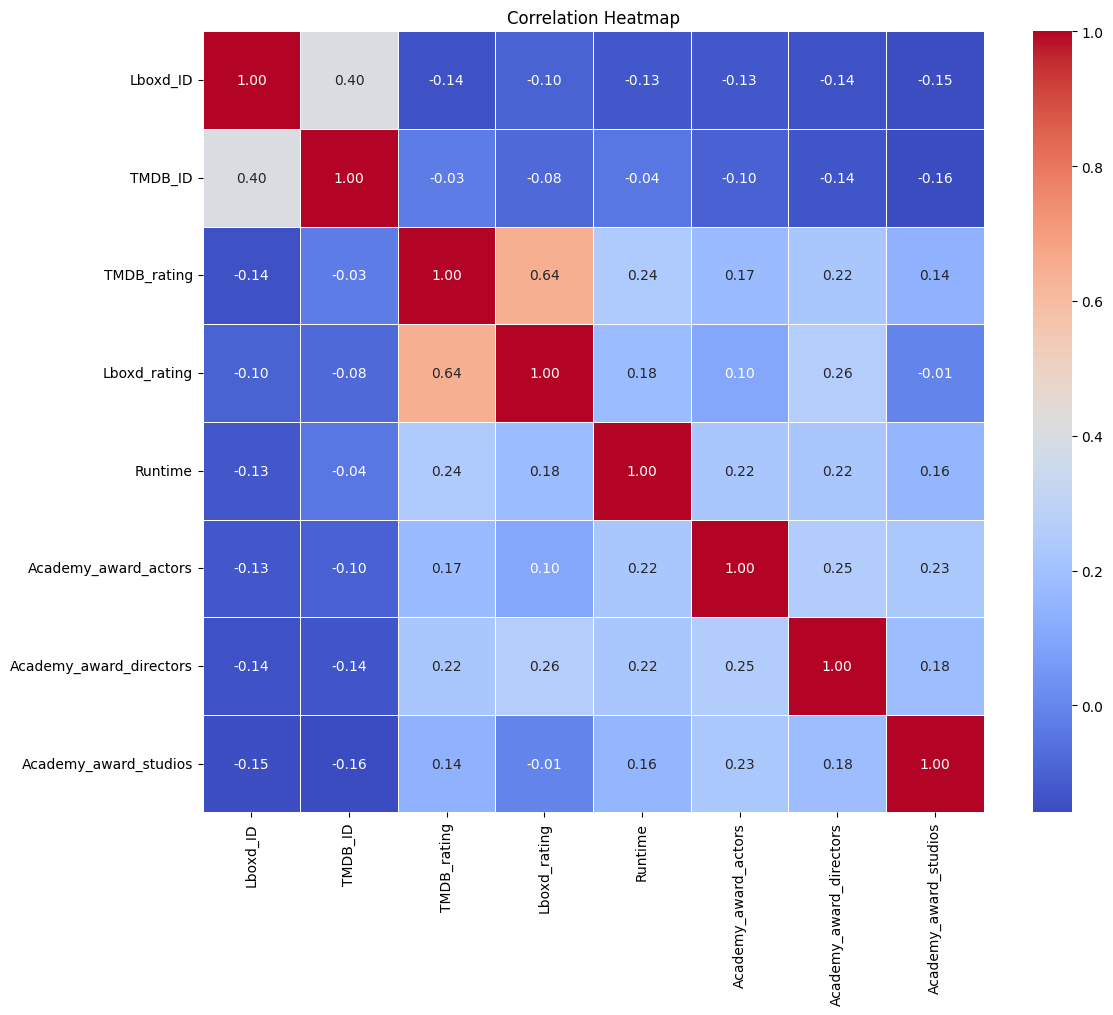

In [8]:
def load_data(test_size, seed, variables_used, output_variable):
    # Method that will load data from a csv file, scale it, and split it into train, validation, and test sets

    # Load the data that we just did all that work on
    df = pd.read_csv("Final_data.csv")

    # Scaling the data
    scaler = StandardScaler()

    df_scaled = df[variables_used].to_numpy()
    df_scaled = scaler.fit_transform(df_scaled)

    X_data_scaled = df_scaled
    Y_data = df[output_variable].to_numpy()
    # Y_data_scaled = output_scaler.fit_transform(Y_data.reshape(-1,1))
    # Y_data_scaled = Y_data_scaled.ravel()
    Y_data_scaled = Y_data.ravel()

    # Splitting all data 80/20 into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_data_scaled, Y_data_scaled, test_size=test_size, random_state=seed)
    # Splitting 20% of data in half into validation and testing sets (test will only be used at the very end)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=seed)
    return X_train, X_val, X_test, y_train, y_val, y_test

def variable_importance(X_train, X_val, y_train, y_val, seed, variables):
    # Method that will display the importance of each variable based on a decision tree
    model = DecisionTreeRegressor(max_depth=8, min_samples_leaf=25, random_state=seed, max_leaf_nodes=80)
    np.random.seed(seed)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    r2_train = r2_score(y_train, y_pred_train)

    y_pred = model.predict(X_val)
    r2_val = r2_score(y_val, y_pred)

    print(f"minSamples 25, maxDepth 8, maxLeaves 80. Tree where Depth {model.get_depth()}, Leaves {model.get_n_leaves()}: train= {r2_train:.3f} val= {r2_val:.3f}")
    for i, importance in enumerate(model.feature_importances_):
        print(f"Variable {i} {variables[i]}: {importance:.4f}")


#Combined_data
df = pd.read_csv("Combined_data.csv")
numeric_df = df.select_dtypes(include='number')

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [9]:
# Keep seed at 42 for consistency
seed = 42
test_size = 0.2

# This is the list of columns that we are using as inputs for models
variables = ['Runtime', 'Academy_award_actors', 'Academy_award_directors', 'Academy_award_studios', 'Drama', 'Comedy',
              'Other', 'Thriller', 'Action', 'Horror', 'Crime', 'Adventure', 'Romance', 'Science_fiction',
              'Fantasy', 'Mystery', 'Family', 'Is_g', 'Is_pg', 'Is_pg13',
              'Is_r', 'Is_nc17', 'Is_nr', 'Is_english']
# Combined_rating is what we are trying to predict
output_variable = 'Combined_rating'
# Split out training, validation, testing datasets
X_train, X_val, X_test, y_train, y_val, y_test = load_data(test_size, seed, variables, output_variable)

# Determine the importance of each variable, based on a decision tree
variable_importance(X_train, X_val, y_train, y_val, seed, variables)

top_variables = ['Runtime', 'Academy_award_actors', 'Academy_award_directors', 'Drama',
              'Other', 'Thriller', 'Action', 'Horror', 'Adventure', 'Is_pg13', 'Is_nr', 'Is_english']
# Combined_rating is what we are trying to predict
output_variable = 'Combined_rating'
# Split out training, validation, testing datasets
X_train, X_val, X_test, y_train, y_val, y_test = load_data(test_size, seed, top_variables, output_variable)

minSamples 25, maxDepth 8, maxLeaves 80. Tree where Depth 8, Leaves 80: train= 0.303 val= 0.290
Variable 0 Runtime: 0.1440
Variable 1 Academy_award_actors: 0.0249
Variable 2 Academy_award_directors: 0.1426
Variable 3 Academy_award_studios: 0.0091
Variable 4 Drama: 0.2754
Variable 5 Comedy: 0.0066
Variable 6 Other: 0.1573
Variable 7 Thriller: 0.0116
Variable 8 Action: 0.0219
Variable 9 Horror: 0.0140
Variable 10 Crime: 0.0064
Variable 11 Adventure: 0.0115
Variable 12 Romance: 0.0051
Variable 13 Science_fiction: 0.0000
Variable 14 Fantasy: 0.0049
Variable 15 Mystery: 0.0024
Variable 16 Family: 0.0039
Variable 17 Is_g: 0.0010
Variable 18 Is_pg: 0.0000
Variable 19 Is_pg13: 0.0305
Variable 20 Is_r: 0.0009
Variable 21 Is_nc17: 0.0000
Variable 22 Is_nr: 0.0114
Variable 23 Is_english: 0.1144


In [10]:
def run_models(models, X_train, X_val, y_train, y_val, seed):
    # Method that will run each model passed into it (only scikit learn)
    for model_name, model in models.items():
      np.random.seed(seed)
      model.fit(X_train, y_train)

      y_pred_train = model.predict(X_train)
      mse_train = mean_squared_error(y_train, y_pred_train)
      mae_train = mean_absolute_error(y_train, y_pred_train)
      r2_train = r2_score(y_train, y_pred_train)

      y_pred = model.predict(X_val)
      mse = mean_squared_error(y_val, y_pred)
      mae = mean_absolute_error(y_val, y_pred)
      r2 = r2_score(y_val, y_pred)

      print(f"Performance of {model_name}:")
      print(f"  MSE: train= {mse_train:.3f} val= {mse:.3f}")
      print(f"  MAE: train= {mae_train:.3f} val= {mae:.3f}")
      print(f"  R²: train= {r2_train:.3f} val= {r2:.3f}")
      if model_name == "Decision Tree":
          print(f"  Tree Depth: {model.get_depth()}")
      if model_name in ["Random Forest"]:
          print(f"  Number of Trees: {model.n_estimators}")
      print("-" * 30)

def make_nn_model(X_train, X_val, y_train, y_val, layer1_nodes, layer2_nodes):
    # Creates a nn model with given number of nodes in the first and second layers (if 2nd input is 0, then the nn will only have 1 layer)
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    feat_dim = train_loader.dataset[0][0].shape[0]

    # Define the model
    class MLPModel(nn.Module):
        def __init__(self, feat_dim):
            self.layer1_size = layer1_nodes
            self.layer2_size = layer2_nodes
            self.X_train_tensor = X_train_tensor
            self.y_train_tensor = y_train_tensor
            self.X_val_tensor = X_val_tensor
            self.y_val_tensor = y_val_tensor
            super(MLPModel, self).__init__()
            if (self.layer1_size == 0):
                self.fc1 = nn.Linear(feat_dim, 1)
            elif(self.layer2_size > 0):
                self.fc1 = nn.Linear(feat_dim, layer1_nodes)
                self.fc2 = nn.Linear(layer1_nodes, layer2_nodes)
                self.fc3 = nn.Linear(layer2_nodes, 1)
            else:
                self.fc1 = nn.Linear(feat_dim, layer1_nodes)
                self.fc2 = nn.Linear(layer1_nodes, 1)

        def forward(self, x):
            if (self.layer1_size == 0):
                x = self.fc1(x)
            elif (self.layer2_size > 0):
                x = F.relu(self.fc1(x))
                x = F.relu(self.fc2(x))
                x = self.fc3(x)
            else:
                x = F.relu(self.fc1(x))
                x = self.fc2(x)
            return x

    model = MLPModel(feat_dim=feat_dim)
    return model, train_loader, val_loader

def train_nn_model(model, train_loader, val_loader):
    # Trains a given nn model
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"Performance of NN size {model.layer1_size} {model.layer2_size}:")
    epochs = 100
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, targets) in enumerate(train_loader):
            outputs = model(data)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)

        def evaluate(loader, model):
            model.eval()
            total_loss = 0.0
            with torch.no_grad():
                for data, targets in loader:
                    loss = criterion(model(data), targets)
                    total_loss += loss.item()
            return total_loss / len(loader)

        train_loss = evaluate(train_loader, model)
        val_loss = evaluate(val_loader, model)
        # print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss:.4f}, val Loss: {val_loss:.4f}')

    def eval_predictions(loader, model):
        model.eval()
        with torch.no_grad():
            predictions = model(loader)
        return predictions

    pred_train = eval_predictions(model.X_train_tensor, model)
    r2_train = r2_score(y_train, pred_train)

    pred_val = eval_predictions(model.X_val_tensor, model)
    r2_val = r2_score(y_val, pred_val)
    print(f"Training R-squared: {r2_train:.4f}, val R-squared: {r2_val:.4f}")
    return model

# Run all models with default parameters
models = {
    "Linear Regression": LinearRegression(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=seed),
    "Random Forest": RandomForestRegressor(random_state=seed)
}
run_models(models, X_train, X_val, y_train, y_val, seed)
# Creates and runs a nn model with given number of nodes in the first and second layers
model, train_loader, val_loader = make_nn_model(X_train, X_val, y_train, y_val, 64, 32)
model = train_nn_model(model, train_loader, val_loader)

Performance of Linear Regression:
  MSE: train= 0.235 val= 0.219
  MAE: train= 0.370 val= 0.367
  R²: train= 0.246 val= 0.289
------------------------------
Performance of K-Nearest Neighbors:
  MSE: train= 0.176 val= 0.233
  MAE: train= 0.321 val= 0.371
  R²: train= 0.434 val= 0.243
------------------------------
Performance of Decision Tree:
  MSE: train= 0.061 val= 0.373
  MAE: train= 0.120 val= 0.467
  R²: train= 0.805 val= -0.210
  Tree Depth: 33
------------------------------
Performance of Random Forest:
  MSE: train= 0.083 val= 0.255
  MAE: train= 0.206 val= 0.385
  R²: train= 0.733 val= 0.174
  Number of Trees: 100
------------------------------
Performance of NN size 64 32:
Training R-squared: 0.3200, val R-squared: 0.2991


In [11]:
def try_forest_parameters(X_train, X_val, y_train, y_val, seed):
    # Tries 1 to 20 as a max depth for trees in a random forest
    depth_r2_list = []
    max_depth = 20
    print("-----------Depth-------------")
    for curr_depth in range(1, max_depth):
        model = RandomForestRegressor(max_depth=curr_depth, random_state=seed)
        np.random.seed(seed)
        model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        r2_train = r2_score(y_train, y_pred_train)

        y_pred = model.predict(X_val)
        r2_val = r2_score(y_val, y_pred)

        print(f"Performance of Forest Tree Depth={model.max_depth}: train= {r2_train:.3f} val= {r2_val:.3f}")
        depth_r2_list.append([curr_depth, r2_train, r2_val])

    # Tries 10 to 300 (stepping by 10) as a number of leaves for trees in a random forest
    leaves_r2_list = []
    max_leaves = 30
    print("-----------Leaves-------------")
    for curr_leaves in range(1, max_leaves):
        model = RandomForestRegressor(random_state=seed, max_leaf_nodes=curr_leaves*10)
        np.random.seed(seed)
        model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        r2_train = r2_score(y_train, y_pred_train)

        y_pred = model.predict(X_val)
        r2_val = r2_score(y_val, y_pred)

        print(f"Performance of Forest Tree maxLeaves={curr_leaves*10}: train= {r2_train:.3f} val= {r2_val:.3f}")
        leaves_r2_list.append([curr_leaves, r2_train, r2_val])

    # Tries a random forest with the best parameters found above
    print("-----------Best Parameters-------------")
    model = RandomForestRegressor(max_depth=10, random_state=seed, max_leaf_nodes=160)
    np.random.seed(seed)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    r2_train = r2_score(y_train, y_pred_train)

    y_pred = model.predict(X_val)
    r2_val = r2_score(y_val, y_pred)
    print(f"Forest Tree maxDepth={model.max_depth} maxLeaves={model.max_leaf_nodes}: train= {r2_train:.3f} val= {r2_val:.3f}")
    return depth_r2_list, leaves_r2_list, model

# Best Random Forest: depth=10, leaves=160, best val R2=0.329
depth_r2_list, leaves_r2_list, best_model = try_forest_parameters(X_train, X_val, y_train, y_val, seed)
models = {
    "Random Forest": best_model
}
run_models(models, X_train, X_val, y_train, y_val, seed)

-----------Depth-------------
Performance of Forest Tree Depth=1: train= 0.084 val= 0.088
Performance of Forest Tree Depth=2: train= 0.157 val= 0.174
Performance of Forest Tree Depth=3: train= 0.213 val= 0.236
Performance of Forest Tree Depth=4: train= 0.246 val= 0.267
Performance of Forest Tree Depth=5: train= 0.276 val= 0.291
Performance of Forest Tree Depth=6: train= 0.305 val= 0.307
Performance of Forest Tree Depth=7: train= 0.335 val= 0.317
Performance of Forest Tree Depth=8: train= 0.368 val= 0.323
Performance of Forest Tree Depth=9: train= 0.404 val= 0.326
Performance of Forest Tree Depth=10: train= 0.444 val= 0.323
Performance of Forest Tree Depth=11: train= 0.486 val= 0.313
Performance of Forest Tree Depth=12: train= 0.529 val= 0.305
Performance of Forest Tree Depth=13: train= 0.571 val= 0.292
Performance of Forest Tree Depth=14: train= 0.609 val= 0.276
Performance of Forest Tree Depth=15: train= 0.643 val= 0.262
Performance of Forest Tree Depth=16: train= 0.670 val= 0.247
Per

After testing out five different types of models—a Linear Regression, a K-Nearest Neighbors, a Decision Tree, a Random Forest, and a Neural Network, with various hyperparameters—we determined that the Random Forest model was generally performing best, with the highest overall R^2 on the validation dataset. Our best Linear Regression validation R2 was 0.289, our best KNN validation R2 was 0.302, our best Decision Tree validation R2 was 0.305, our best Random Forest validation R2 was 0.329, and our best Neural Network validation R2 was 0.325. We tested the hyperparameters for each model, but we only shared the code for the Random Forest because that ended up being the best model.

| Model Name       | Parameters Specified                  | Model Validation R² |
|------------------|----------------------------------------|----------------------|
| Linear Regression| N/A                                    | 0.289                |
| KNN              | K = 23                                 | 0.302                |
| Decision Tree    | MaxDepth = 7, MaxLeaves = 100         | 0.305                |
| Random Forest    | MaxDepth = 10, MaxLeaves = 160        | 0.329                |
| Neural Network   | Layer 1 Nodes = 16, Layer 2 Nodes = 4 | 0.325                |

In [12]:
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Final Test R2 for Random Forest: {r2:.3f}")

Final Test R2 for Random Forest: 0.289


A Random Forest model ended up working best on this dataset because it combines the predictions of many decision trees to improve accuracy and reduce overfitting. Because of this, it is able to handle more complicated relationships between variables.

(Source: “What are the Advantages and Disadvantages of Random Forest?” (2024). https://www.geeksforgeeks.org/machine-learning/what-are-the-advantages-and-disadvantages-of-random-forest/.)


After training our Random Forest model using the training set and validating it using the validation set, we did a final test to see if it continued to perform well with the test set. The model still performed well on the test set, with an R2 of 0.289, although this is slightly lower than the R2 of the validation set with the same parameters.


##Visualization
These first plots are a visualization of the performance of our Random Forest model with each parameter increment. As you can see, there is an obvious point on both graphs where the model performed the best, so it was those parameters that we used for our final version of the model.

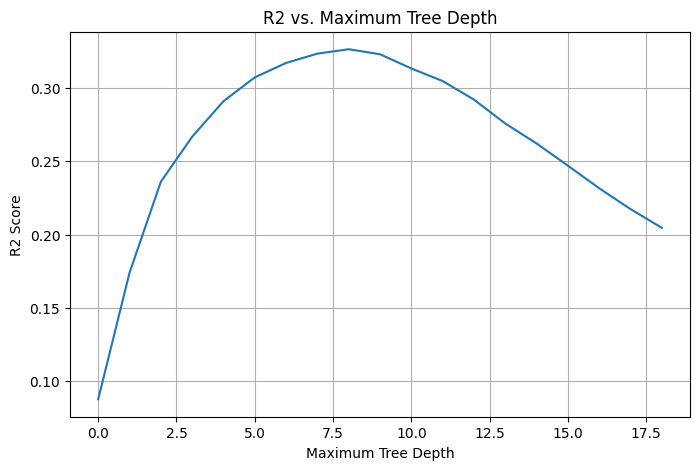

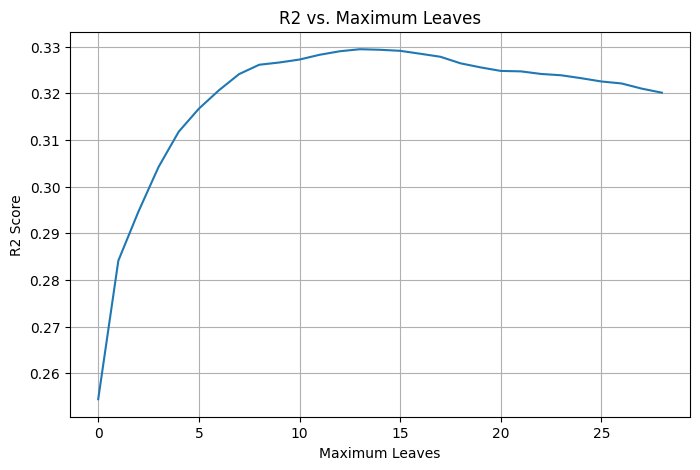

In [13]:
def plot_parameters(r2_list, title):
    # Method that will plot the r2 values for a model in relation to whatever parameter was being changed for that model
    plt.figure(figsize=(8,5))
    plt.plot(r2_list)
    plt.title(f"R2 vs. {title}")
    plt.xlabel(f"{title}")
    plt.ylabel("R2 Score")
    plt.grid(True)
    plt.show()

depth_val_r2 = [entry[2] for entry in depth_r2_list]
leaves_val_r2 = [entry[2] for entry in leaves_r2_list]
plot_parameters(depth_val_r2, "Maximum Tree Depth")
plot_parameters(leaves_val_r2, "Maximum Leaves")


Here is an example of one of the trees from the Random Forest model. We decided to only display one of the trees in our forest because the forest is made up of many trees, and they all look almost identical. We picked the first of the trees to display as an example of what the trees in the forest look like for the most part.

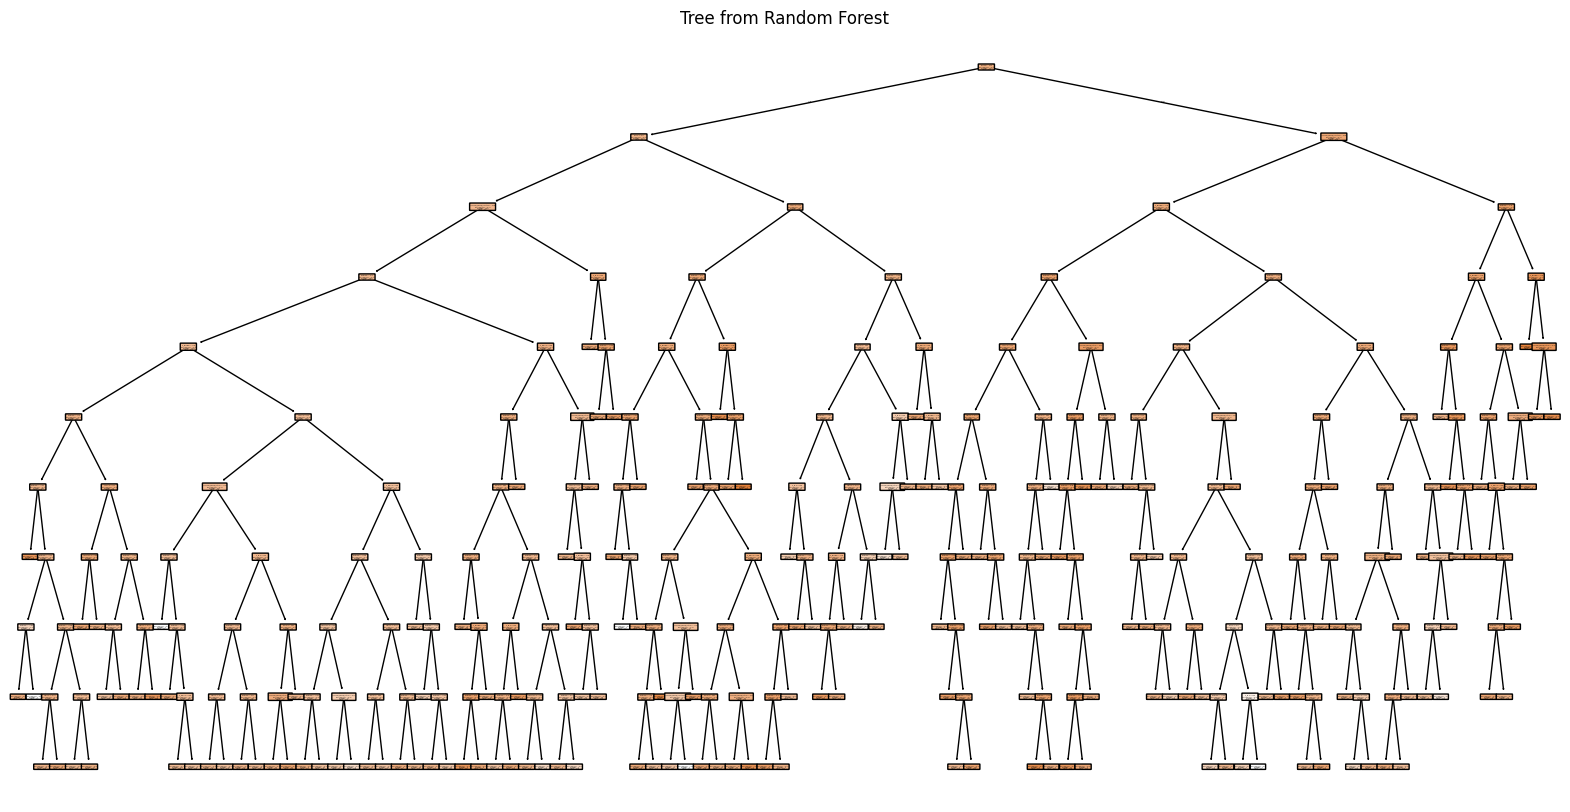

In [14]:
# Pick the first tree from the RandomForest
tree = best_model.estimators_[0]

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(
    tree,
    feature_names=top_variables,
    filled=True,
    rounded=True,
    precision=2
)
plt.title("Tree from Random Forest")
plt.show()


##Insights and Conclusions
The main goal of this project was determining what features of a movie influence the rating it is given by the general public. Through our various stages of data analyses (the initial exploratory analysis, the primary analysis, and the visualization of the results of these analyses), we believe we have provided insight into specifically naming the different variables that affect a movie’s rating, as well as the importance of those different variables in their influence on rating. An uninformed reader would be able to easily see we determined the most significant variables to be runtime, the number of Academy Award-winning actors, the number of Academy Award-winning directors, a genre classification of Drama, Thriller, Action, Horror, Adventure, and/or Other, a rating of PG-13 or Not Rated, and the movie’s language being in English.

A reader who is more informed, for instance someone who already knows that a movie’s runtime affects the movie’s rating, would still be able to learn from our project because they would likely not be able to specify the order of importance of the variables that affect movie rating. Our project clearly states the variables our analyses found to be most influential, and additionally provides each variables’ importance with a numeric value. We also provide figures, such as a correlation heatmap for the influential variables, that visually display information to help both uninformed and informed readers better understand the claims our data makes with clear and descriptive visuals.

In conclusion, our in-depth exploration of movies, their characteristics, and their ratings has revealed the movie features that most influence how a movie is rated by the general public through movie-rating apps such as Letterboxd, as well how influential each individual feature is. By testing various models and employing different techniques, we were able to choose the model with the best performance and use the insights provided by its results to answer our main questions. We used various figures, such as bar graphs, heatmaps, and line graphs, to visualize our findings to readers at various stages of our project. We hope our project allows anyone asking similar questions to the ones we first posed to better understand not only movies and movie ratings, but also data curation, data visualization, data analysis, and machine learning techniques.